# **Load Data**

In [64]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import SpeechT5Tokenizer
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import load_dataset, Audio
from collections import defaultdict
import matplotlib.pyplot as plt

In [7]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
tokenizer = SpeechT5Tokenizer.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [49]:
dataset = load_dataset(
    "facebook/voxpopuli", "en", streaming=True, trust_remote_code=True
)
dataset = {
    'train': dataset["train"],
    'validation': dataset["validation"],
    'test': dataset["test"]
}

---

# **Data preprocessing**

#  **Ensure that the text is properly cleaned for tokenization,addressing any unsupported characters and replacing them as needed**

In [33]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = tuple(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

# Initialize a dictionary to store results
split_results = {}

# Loop over splits
for split_name in ['train', 'test', 'validation']:
    print(f"Processing {split_name} split...")
    
    all_vocabs = set()
    all_text = []
    
    for i, row in enumerate(dataset[split_name]):
        chars = extract_all_chars(row)
        if '1' in chars['vocab'][0] : 
            print(row)
            print(row['normalized_text'])
        all_vocabs.update(chars["vocab"])
        all_text.append(chars["all_text"])
        
        if (i + 1) % 1000 == 0:
            print(f"{i + 1} elements are done for {split_name}")
    
    # Store results for the split
    split_results[split_name] = {
        "vocab": all_vocabs,
        "all_text": all_text
    }

train_vocab = split_results['train']['vocab']
test_vocab = split_results['test']['vocab']
validation_vocab = split_results['validation']['vocab']

Processing train split...
1000 elements are done for train
2000 elements are done for train
3000 elements are done for train
4000 elements are done for train
5000 elements are done for train
6000 elements are done for train
7000 elements are done for train
8000 elements are done for train
9000 elements are done for train
10000 elements are done for train
11000 elements are done for train
12000 elements are done for train
13000 elements are done for train
14000 elements are done for train
15000 elements are done for train
16000 elements are done for train
17000 elements are done for train
18000 elements are done for train
19000 elements are done for train
20000 elements are done for train
21000 elements are done for train
22000 elements are done for train
23000 elements are done for train
24000 elements are done for train
25000 elements are done for train
26000 elements are done for train
27000 elements are done for train
28000 elements are done for train
29000 elements are done for tra

In [34]:
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}
vocab = set()
for t in train_vocab:
    vocab.update(t)
print("Dataset Vocabulary Size:", vocab)

Dataset Vocabulary Size: {'q', 'm', 'g', 'v', 'x', 'j', 'b', 't', 'a', 'y', 'u', 'n', '.', 's', '!', 'h', 'c', 'w', 'i', ' ', 'p', 'z', '1', 'l', 'o', 'k', "'", 'r', 'd', ';', 'e', '?', 'f'}


In [35]:
vocab - tokenizer_vocab

{' ', '1'}

**The following example contained 1**

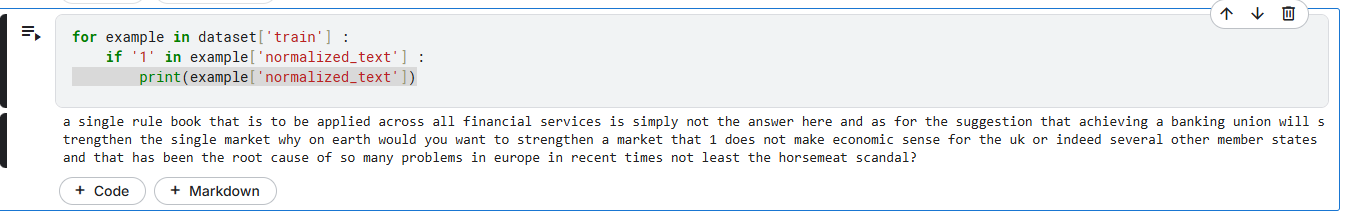

In [57]:
for row in dataset['train'] : 
    print(row)
    break

{'audio_id': '20180418-0900-PLENARY-3-en_20180418-08:50:36_17', 'language': 0, 'audio': {'path': 'train_part_0/20180418-0900-PLENARY-3-en_20180418-08:50:36_17.wav', 'array': array([-0.00030518,  0.00119019,  0.00506592, ..., -0.00036621,
       -0.00027466, -0.00018311]), 'sampling_rate': 16000}, 'raw_text': 'If you do not address this problem, the ground is there for populist nationalist forces to go on growing all over Europe.', 'normalized_text': 'if you do not address this problem the ground is there for populist nationalist forces to go on growing all over europe.', 'gender': 'female', 'speaker_id': '124737', 'is_gold_transcript': True, 'accent': 'None'}


**el mafrood en el tokenizer byt3aml m3 el spaces hwa**

In [61]:
print("Hello world")

Hello world


**Replace the tokens not found in the tokenizer vocab**

In [58]:
def apply_cleanup_to_streamed_dataset(dataset, replacements):
    for i, item in enumerate(dataset['train']):
        item["normalized_text"] = item["normalized_text"].replace('1', 'one')

apply_cleanup_to_streamed_dataset(dataset, replacements)

---

## **Analyze the distribution of speakers within the dataset and filter to maintain a balanced representation.**

In [67]:
next(iter(dataset['train']))

{'audio_id': '20180418-0900-PLENARY-3-en_20180418-08:50:36_17',
 'language': 0,
 'audio': {'path': 'train_part_0/20180418-0900-PLENARY-3-en_20180418-08:50:36_17.wav',
  'array': array([-0.00030518,  0.00119019,  0.00506592, ..., -0.00036621,
         -0.00027466, -0.00018311]),
  'sampling_rate': 16000},
 'raw_text': 'If you do not address this problem, the ground is there for populist nationalist forces to go on growing all over Europe.',
 'normalized_text': 'if you do not address this problem the ground is there for populist nationalist forces to go on growing all over europe.',
 'gender': 'female',
 'speaker_id': '124737',
 'is_gold_transcript': True,
 'accent': 'None'}

In [69]:
speakers = defaultdict(int)
for row in dataset['train']:
  # for id in batch['speaker_id']:
    
    id = row['speaker_id']
    # print(id)
    # break
    if id is not None:
      speakers[id] += 1

In [83]:
counter = 0 
for k , v in speakers.items()  : 
    if 100<=v <= 200 : 
        counter += v  
print(counter)

12568


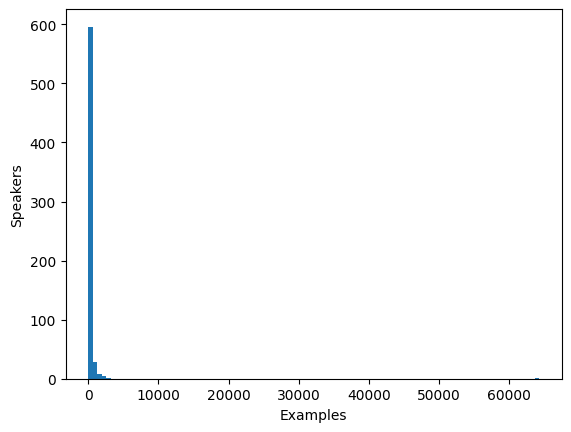

In [77]:
plt.figure()
plt.hist(speakers.values(), bins=100)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [93]:
def filter_speakers(batch):
    valid_speakers = [
        speaker_id for speaker_id in batch["speaker_id"]
        if 100 <= speakers.get(speaker_id, 0) <= 200
    ]
    return len(valid_speakers) > 0

In [ ]:
filtered_dataset = dataset['train'].filter(filter_speakers)

In [103]:
counter = 0
unique = 0
with open("speakers_in_range.txt", "w") as file:
    for k, v in speakers.items():
        if 100 <= v <= 200:
            unique +=1
            counter += v
            file.write(f"{k}\n")  # Write the key (speaker ID) to the file
print(f"dataset current length is {counter}")
print(f"There are {unique} unique speakers")

dataset current length is 12568
There are 90 unique speakers


In [99]:
filename = "/kaggle/working/speakers_in_range.txt"

with open(filename, "r") as file:
    line_count = sum(1 for line in file)

print(f"The file {filename} contains {line_count} lines.")


The file /kaggle/working/speakers_in_range.txt contains 90 lines.


---